In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Gerber statistic calculation
def gerber_statistic(returns, threshold_factor=0.5):
    n_assets = returns.shape[1]
    gerber_cov = np.zeros((n_assets, n_assets))

    # Calculate thresholds based on standard deviation
    std_devs = returns.std()
    thresholds = threshold_factor * std_devs

    for i in range(n_assets):
        for j in range(i, n_assets):
            concordant = discordant = 0

            for t in range(len(returns)):
                r_i = returns.iloc[t, i]
                r_j = returns.iloc[t, j]

                if (r_i > thresholds.iloc[i] and r_j > thresholds.iloc[j]) or (r_i < -thresholds.iloc[i] and r_j < -thresholds.iloc[j]):


                total_pairs = concordant + discordant
            if total_pairs > 0:
                gerber_stat = (concordant - discordant) / total_pairs
            else:
                gerber_stat = 0

            gerber_cov[i, j] = gerber_cov[j, i] = gerber_stat

    return gerber_cov

def create_min_variance_portfolio_gerber(returns):
    # Gerber covariance matrix
    gerber_cov_matrix = gerber_statistic(returns)

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(portfolio_variance, init_guess, args=(gerber_cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def get_stock_weightage_gerber(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    # Use Gerber covariance to get portfolio weights
    weights = create_min_variance_portfolio_gerber(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Backtesting with Gerber covariance
def backtest_strategy_gerber(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage_gerber(weekly_returns.iloc[:i], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest with Gerber covariance
print("Running backtest using Gerber covariance...")
portfolio_returns, weightage_history = backtest_strategy_gerber(df)

# Calculate cumulative returns and metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset
last_date = df.index[-1]
try:
    weightage = get_stock_weightage_gerber(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


IndentationError: expected an indented block after 'if' statement on line 39 (<ipython-input-1-f10bcc311175>, line 42)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_weekly_returns(df):
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Gerber statistic calculation
def gerber_statistic(returns, threshold_factor=0.5):
    """
    Calculate the Gerber statistic for a set of asset returns.

    Parameters:
    returns (pd.DataFrame): DataFrame of asset returns with time as index and assets as columns.
    threshold_factor (float): Factor for determining the threshold based on standard deviation.

    Returns:
    np.ndarray: Gerber covariance matrix.
    """
    n_assets = returns.shape[1]
    gerber_cov = np.zeros((n_assets, n_assets))

    # Calculate the thresholds for each asset based on standard deviation
    std_devs = returns.std()
    thresholds = threshold_factor * std_devs

    for i in range(n_assets):
        for j in range(i, n_assets):
            concordant = discordant = 0

            for t in range(len(returns)):
                r_i = returns.iloc[t, i]
                r_j = returns.iloc[t, j]

                # Check for concordant and discordant movements
                if (r_i > thresholds.iloc[i] and r_j > thresholds.iloc[j]) or (r_i < -thresholds.iloc[i] and r_j < -thresholds.iloc[j]):
                    concordant += 1
                elif (r_i > thresholds.iloc[i] and r_j < -thresholds.iloc[j]) or (r_i < -thresholds.iloc[i] and r_j > thresholds.iloc[j]):
                    discordant += 1

            # Compute Gerber statistic
            total_pairs = concordant + discordant
            if total_pairs > 0:
                gerber_stat = (concordant - discordant) / total_pairs
            else:
                gerber_stat = 0

            gerber_cov[i, j] = gerber_cov[j, i] = gerber_stat

    return gerber_cov

def create_min_variance_portfolio_gerber(returns):
    # Calculate the Gerber covariance matrix
    gerber_cov_matrix = gerber_statistic(returns)

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(portfolio_variance, init_guess, args=(gerber_cov_matrix,),
                      method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def get_stock_weightage_gerber(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Not enough historical data before the target date.")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    # Use Gerber covariance to get portfolio weights
    weights = create_min_variance_portfolio_gerber(top_stock_returns)
    stock_weights = dict(zip(top_stocks, weights))

    return stock_weights

def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Backtesting with Gerber covariance
def backtest_strategy_gerber(df):
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    for i in range(50, len(weekly_returns)):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            weightage = get_stock_weightage_gerber(weekly_returns.iloc[:i], current_date)
            top_stocks = list(weightage.keys())
            weights = list(weightage.values())

            next_week_return = weekly_returns.loc[next_week][top_stocks].dot(weights)
            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except ValueError:
            print(f"Skipping week {next_week} due to insufficient data")

    valid_index = weekly_returns.index[50:50+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

# Load the data
df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)

# Run the backtest with Gerber covariance
print("Running backtest using Gerber covariance...")
portfolio_returns, weightage_history = backtest_strategy_gerber(df)

# Calculate cumulative returns and metrics
cumulative_returns = (1 + portfolio_returns).cumprod()
total_return = cumulative_returns.iloc[-1]
profit_only_return = total_return - 1
annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
annualized_volatility = portfolio_returns.std() * np.sqrt(52)
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

# Calculate drawdown and additional metrics
drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
calmar = calmar_ratio(annualized_return, max_drawdown)
sortino = sortino_ratio(portfolio_returns)

# Print backtest results
print("\nBacktest Results:")
print(f"Total Return (including initial capital): {total_return:.4f}")
print(f"This means for every $1 invested, you now have ${total_return:.2f}")
print(f"Profit-only Return: {profit_only_return:.4%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Calmar Ratio: {calmar:.2f}")

# Plot cumulative returns and drawdown
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
cumulative_returns.plot()
plt.title('Cumulative Portfolio Value (Starting from $1)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)

plt.subplot(2, 1, 2)
drawdown.plot(color='red')
plt.title('Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()

# Get weightage for the last date in the dataset
last_date = df.index[-1]
try:
    weightage = get_stock_weightage_gerber(calculate_weekly_returns(df), last_date)
    print(f"\nStock weightage for week of {last_date.date()}:")
    for stock, weight in weightage.items():
        print(f"{stock}: {weight:.4f}")
except ValueError as e:
    print(f"Error: {e}")


<ipython-input-2-d9063b0df848>:136: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Running backtest using Gerber covariance...


KeyboardInterrupt: 

<ipython-input-4-56fa0bfe13d5>:120: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Loading data...
Loaded data with shape: (1238, 51)
Starting backtest...
Calculating weekly returns...
Generated weekly returns with shape: (261, 51)


Backtesting progress: 100%|██████████| 211/211 [03:17<00:00,  1.07it/s]



Backtest Results:
Total Return: 3.3781
Annualized Return: 34.99%


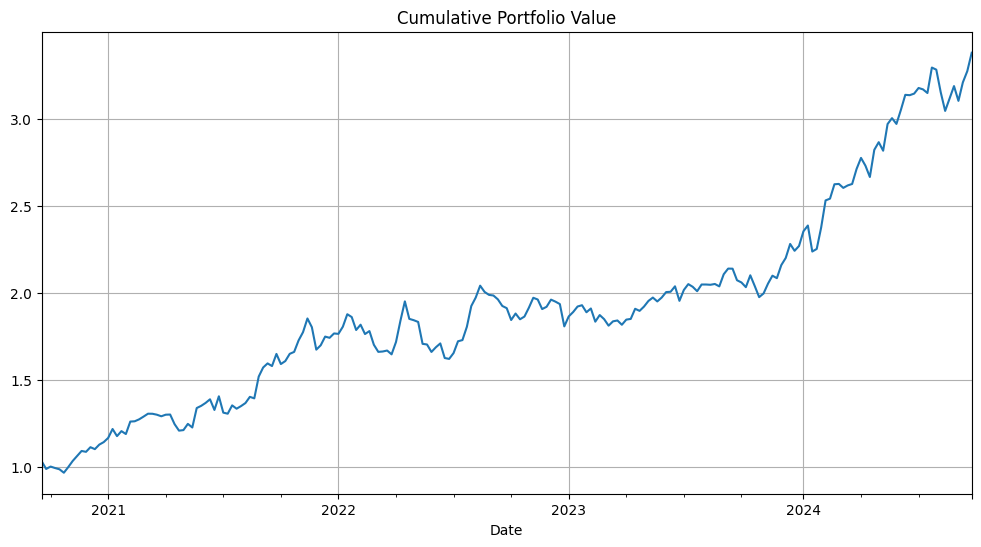

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking

def calculate_weekly_returns(df):
    print("Calculating weekly returns...")
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    print(f"Generated weekly returns with shape: {weekly_returns.shape}")
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def gerber_statistic(returns, threshold_factor=0.5):
    n_assets = returns.shape[1]
    gerber_cov = np.zeros((n_assets, n_assets))

    std_devs = returns.std()
    thresholds = threshold_factor * std_devs

    for i in range(n_assets):
        for j in range(i, n_assets):
            concordant = discordant = 0

            for t in range(len(returns)):
                r_i = returns.iloc[t, i]
                r_j = returns.iloc[t, j]

                if (r_i > thresholds.iloc[i] and r_j > thresholds.iloc[j]) or \
                   (r_i < -thresholds.iloc[i] and r_j < -thresholds.iloc[j]):
                    concordant += 1
                elif (r_i > thresholds.iloc[i] and r_j < -thresholds.iloc[j]) or \
                     (r_i < -thresholds.iloc[i] and r_j > thresholds.iloc[j]):
                    discordant += 1

            total_pairs = concordant + discordant
            gerber_stat = (concordant - discordant) / total_pairs if total_pairs > 0 else 0
            gerber_cov[i, j] = gerber_cov[j, i] = gerber_stat

    return gerber_cov

def create_min_variance_portfolio_gerber(returns):
    gerber_cov_matrix = gerber_statistic(returns)

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    try:
        result = minimize(portfolio_variance, init_guess, args=(gerber_cov_matrix,),
                        method='SLSQP', bounds=bounds, constraints=constraints)
        if not result.success:
            print(f"Optimization warning: {result.message}")
        return result.x
    except Exception as e:
        print(f"Optimization error: {str(e)}")
        return init_guess

def get_stock_weightage_gerber(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Insufficient historical data")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    weights = create_min_variance_portfolio_gerber(top_stock_returns)
    return dict(zip(top_stocks, weights))

def backtest_strategy_gerber(df):
    print("Starting backtest...")
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    # Define the backtesting period
    start_idx = 50  # Need 50 weeks of historical data
    end_idx = len(weekly_returns)

    # Use tqdm for progress tracking
    for i in tqdm(range(start_idx, end_idx), desc="Backtesting progress"):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            # Get portfolio weights for current period
            weightage = get_stock_weightage_gerber(weekly_returns.iloc[:i], current_date)

            # Calculate next week's return
            next_week_return = weekly_returns.loc[next_week][list(weightage.keys())].dot(list(weightage.values()))

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except Exception as e:
            print(f"Error at {next_week}: {str(e)}")
            continue

    valid_index = weekly_returns.index[start_idx:start_idx+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def main():
    try:
        # Load data
        print("Loading data...")
        df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
        print(f"Loaded data with shape: {df.shape}")

        # Run backtest
        portfolio_returns, weightage_history = backtest_strategy_gerber(df)

        if len(portfolio_returns) == 0:
            print("Error: No portfolio returns generated")
            return

        # Calculate performance metrics
        cumulative_returns = (1 + portfolio_returns).cumprod()
        total_return = cumulative_returns.iloc[-1]
        annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)

        # Print results
        print("\nBacktest Results:")
        print(f"Total Return: {total_return:.4f}")
        print(f"Annualized Return: {annualized_return:.2%}")

        # Plot results
        plt.figure(figsize=(12, 6))
        cumulative_returns.plot()
        plt.title('Cumulative Portfolio Value')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

<ipython-input-7-bf031842ed4a>:120: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Loading data...
Loaded data with shape: (1238, 51)
Starting backtest...
Calculating weekly returns...
Generated weekly returns with shape: (261, 51)


Backtesting progress: 100%|██████████| 211/211 [03:17<00:00,  1.07it/s]



Backtest Results:
Total Return (including initial capital): 3.3781
This means for every $1 invested, you now have $3.38
Profit-only Return: 237.8150%
Annualized Return: 34.99%
Annualized Volatility: 20.21%
Sharpe Ratio: 1.59
Sortino Ratio: 1.67
Max Drawdown: -16.91%
Calmar Ratio: 2.07


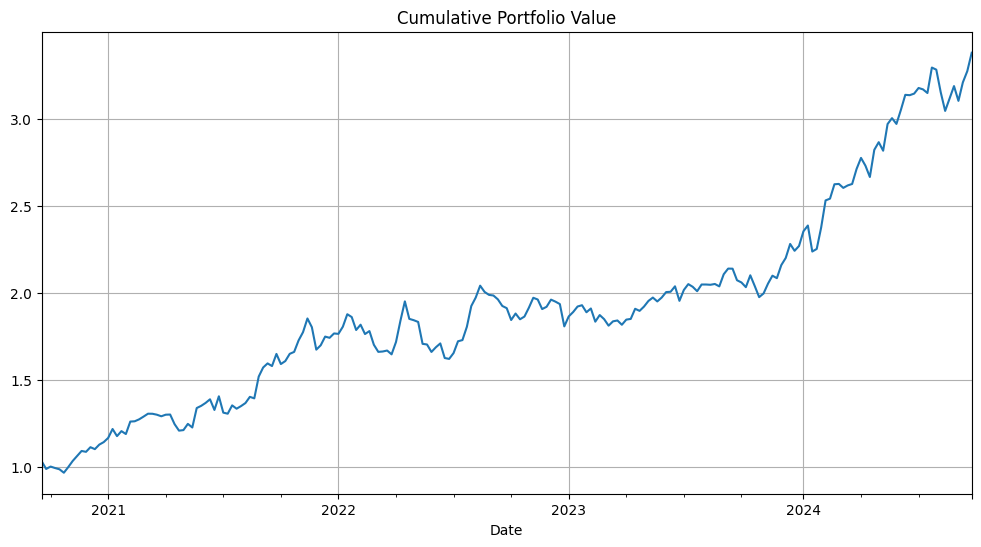

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking

def calculate_weekly_returns(df):
    print("Calculating weekly returns...")
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    print(f"Generated weekly returns with shape: {weekly_returns.shape}")
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def gerber_statistic(returns, threshold_factor=0.5):
    n_assets = returns.shape[1]
    gerber_cov = np.zeros((n_assets, n_assets))

    std_devs = returns.std()
    thresholds = threshold_factor * std_devs

    for i in range(n_assets):
        for j in range(i, n_assets):
            concordant = discordant = 0

            for t in range(len(returns)):
                r_i = returns.iloc[t, i]
                r_j = returns.iloc[t, j]

                if (r_i > thresholds.iloc[i] and r_j > thresholds.iloc[j]) or \
                   (r_i < -thresholds.iloc[i] and r_j < -thresholds.iloc[j]):
                    concordant += 1
                elif (r_i > thresholds.iloc[i] and r_j < -thresholds.iloc[j]) or \
                     (r_i < -thresholds.iloc[i] and r_j > thresholds.iloc[j]):
                    discordant += 1

            total_pairs = concordant + discordant
            gerber_stat = (concordant - discordant) / total_pairs if total_pairs > 0 else 0
            gerber_cov[i, j] = gerber_cov[j, i] = gerber_stat

    return gerber_cov

def create_min_variance_portfolio_gerber(returns):
    gerber_cov_matrix = gerber_statistic(returns)

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    try:
        result = minimize(portfolio_variance, init_guess, args=(gerber_cov_matrix,),
                        method='SLSQP', bounds=bounds, constraints=constraints)
        if not result.success:
            print(f"Optimization warning: {result.message}")
        return result.x
    except Exception as e:
        print(f"Optimization error: {str(e)}")
        return init_guess

def get_stock_weightage_gerber(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Insufficient historical data")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    weights = create_min_variance_portfolio_gerber(top_stock_returns)
    return dict(zip(top_stocks, weights))

def backtest_strategy_gerber(df):
    print("Starting backtest...")
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    # Define the backtesting period
    start_idx = 50  # Need 50 weeks of historical data
    end_idx = len(weekly_returns)

    # Use tqdm for progress tracking
    for i in tqdm(range(start_idx, end_idx), desc="Backtesting progress"):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            # Get portfolio weights for current period
            weightage = get_stock_weightage_gerber(weekly_returns.iloc[:i], current_date)

            # Calculate next week's return
            next_week_return = weekly_returns.loc[next_week][list(weightage.keys())].dot(list(weightage.values()))

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except Exception as e:
            print(f"Error at {next_week}: {str(e)}")
            continue

    valid_index = weekly_returns.index[start_idx:start_idx+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def main():
    try:
        # Load data
        print("Loading data...")
        df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
        print(f"Loaded data with shape: {df.shape}")

        # Run backtest
        portfolio_returns, weightage_history = backtest_strategy_gerber(df)

        if len(portfolio_returns) == 0:
            print("Error: No portfolio returns generated")
            return

        # Calculate cumulative returns and metrics
        cumulative_returns = (1 + portfolio_returns).cumprod()
        total_return = cumulative_returns.iloc[-1]
        profit_only_return = total_return - 1
        annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
        annualized_volatility = portfolio_returns.std() * np.sqrt(52)
        sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

        # Calculate drawdown and additional metrics
        drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
        calmar = calmar_ratio(annualized_return, max_drawdown)
        sortino = sortino_ratio(portfolio_returns)

        # Print backtest results
        print("\nBacktest Results:")
        print(f"Total Return (including initial capital): {total_return:.4f}")
        print(f"This means for every $1 invested, you now have ${total_return:.2f}")
        print(f"Profit-only Return: {profit_only_return:.4%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Annualized Volatility: {annualized_volatility:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        print(f"Calmar Ratio: {calmar:.2f}")

        # Plot results
        plt.figure(figsize=(12, 6))
        cumulative_returns.plot()
        plt.title('Cumulative Portfolio Value')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()


<ipython-input-3-6215c660c00a>:135: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)


Loading data...
Loaded data with shape: (1238, 51)
Starting backtest...
Calculating weekly returns...
Generated weekly returns with shape: (261, 51)


Backtesting progress: 100%|██████████| 211/211 [03:04<00:00,  1.14it/s]



Backtest Results:
Total Return (including initial capital): 3.8465
This means for every $1 invested, you now have $3.85
Profit-only Return: 284.6522%
Annualized Return: 39.38%
Annualized Volatility: 19.15%
Sharpe Ratio: 1.83
Sortino Ratio: 2.12
Max Drawdown: -13.35%
Calmar Ratio: 2.95


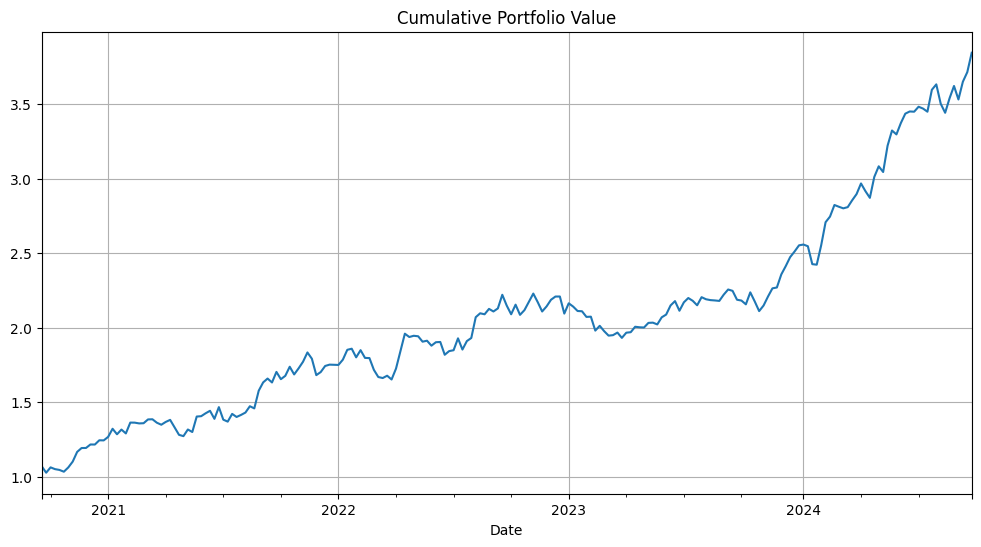

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress tracking

def calculate_weekly_returns(df):
    print("Calculating weekly returns...")
    weekly_data = df.resample('W').last()
    weekly_returns = weekly_data.pct_change().dropna()
    print(f"Generated weekly returns with shape: {weekly_returns.shape}")
    return weekly_returns

def rank_stocks(weekly_returns, window=50):
    avg_returns = weekly_returns.rolling(window=window).mean()
    latest_avg_returns = avg_returns.iloc[-1].sort_values(ascending=False)
    return latest_avg_returns.index.tolist()

def get_top_stocks(ranked_stocks, n=20):
    return ranked_stocks[:n]

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def gerber_statistic(returns, threshold_factor=0.4):
    n_assets = returns.shape[1]
    gerber_cov = np.zeros((n_assets, n_assets))

    std_devs = returns.std()
    thresholds = threshold_factor * std_devs

    for i in range(n_assets):
        for j in range(i, n_assets):
            concordant = discordant = 0

            for t in range(len(returns)):
                r_i = returns.iloc[t, i]
                r_j = returns.iloc[t, j]

                if (r_i > thresholds.iloc[i] and r_j > thresholds.iloc[j]) or \
                   (r_i < -thresholds.iloc[i] and r_j < -thresholds.iloc[j]):
                    concordant += 1
                elif (r_i > thresholds.iloc[i] and r_j < -thresholds.iloc[j]) or \
                     (r_i < -thresholds.iloc[i] and r_j > thresholds.iloc[j]):
                    discordant += 1

            total_pairs = concordant + discordant
            gerber_stat = (concordant - discordant) / total_pairs if total_pairs > 0 else 0
            gerber_cov[i, j] = gerber_cov[j, i] = gerber_stat

    return gerber_cov

def create_min_variance_portfolio_gerber(returns):
    gerber_cov_matrix = gerber_statistic(returns)

    n = len(returns.columns)
    init_guess = np.array([1/n for _ in range(n)])
    bounds = tuple((0, 1) for _ in range(n))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    try:
        result = minimize(portfolio_variance, init_guess, args=(gerber_cov_matrix,),
                        method='SLSQP', bounds=bounds, constraints=constraints)
        if not result.success:
            print(f"Optimization warning: {result.message}")
        return result.x
    except Exception as e:
        print(f"Optimization error: {str(e)}")
        return init_guess


def calculate_drawdown(cumulative_returns):
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def sortino_ratio(returns, target=0, periods_per_year=52):
    downside_returns = returns[returns < target]
    downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(periods_per_year)
    annualized_return = returns.mean() * periods_per_year
    return annualized_return / downside_deviation if downside_deviation != 0 else np.nan

def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

def get_stock_weightage_gerber(weekly_returns, current_date):
    data_slice = weekly_returns.loc[:current_date].iloc[-50:]

    if len(data_slice) < 50:
        raise ValueError("Insufficient historical data")

    ranked_stocks = rank_stocks(data_slice)
    top_stocks = get_top_stocks(ranked_stocks)
    top_stock_returns = data_slice[top_stocks]

    weights = create_min_variance_portfolio_gerber(top_stock_returns)
    return dict(zip(top_stocks, weights))

def backtest_strategy_gerber(df):
    print("Starting backtest...")
    weekly_returns = calculate_weekly_returns(df)
    portfolio_returns = []
    weightage_history = []

    # Define the backtesting period
    start_idx = 50  # Need 50 weeks of historical data
    end_idx = len(weekly_returns)

    # Use tqdm for progress tracking
    for i in tqdm(range(start_idx, end_idx), desc="Backtesting progress"):
        current_date = weekly_returns.index[i-1]
        next_week = weekly_returns.index[i]

        try:
            # Get portfolio weights for current period
            weightage = get_stock_weightage_gerber(weekly_returns.iloc[:i], current_date)

            # Calculate next week's return
            next_week_return = weekly_returns.loc[next_week][list(weightage.keys())].dot(list(weightage.values()))

            portfolio_returns.append(next_week_return)
            weightage_history.append((next_week, weightage))

        except Exception as e:
            print(f"Error at {next_week}: {str(e)}")
            continue

    valid_index = weekly_returns.index[start_idx:start_idx+len(portfolio_returns)]
    return pd.Series(portfolio_returns, index=valid_index), weightage_history

def main():
    try:
        # Load data
        print("Loading data...")
        df = pd.read_csv('total_df.csv', index_col='Date', parse_dates=True)
        print(f"Loaded data with shape: {df.shape}")

        # Run backtest
        portfolio_returns, weightage_history = backtest_strategy_gerber(df)

        if len(portfolio_returns) == 0:
            print("Error: No portfolio returns generated")
            return

        # Calculate cumulative returns and metrics
        cumulative_returns = (1 + portfolio_returns).cumprod()
        total_return = cumulative_returns.iloc[-1]
        profit_only_return = total_return - 1
        annualized_return = (total_return ** (52/len(cumulative_returns)) - 1)
        annualized_volatility = portfolio_returns.std() * np.sqrt(52)
        sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(52)

        # Calculate drawdown and additional metrics
        drawdown, max_drawdown = calculate_drawdown(cumulative_returns)
        calmar = calmar_ratio(annualized_return, max_drawdown)
        sortino = sortino_ratio(portfolio_returns)

        # Print backtest results
        print("\nBacktest Results:")
        print(f"Total Return (including initial capital): {total_return:.4f}")
        print(f"This means for every $1 invested, you now have ${total_return:.2f}")
        print(f"Profit-only Return: {profit_only_return:.4%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Annualized Volatility: {annualized_volatility:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Sortino Ratio: {sortino:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        print(f"Calmar Ratio: {calmar:.2f}")

        # Plot results
        plt.figure(figsize=(12, 6))
        cumulative_returns.plot()
        plt.title('Cumulative Portfolio Value')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()
